# 06 — Model Training (Hopsworks Feature Store)

This notebook trains forecasting models using the **engineered traffic features** plus **weather** and **TfL disruption** features stored in Hopsworks Feature Groups.

**Targets / labels** come from a separate Label Feature Group (generated in your label backfill notebook):
- `label_speed_ratio_t_plus_30`
- `label_speed_ratio_t_plus_60`

The notebook:
1. Logs into Hopsworks
2. Reads Feature Groups into pandas
3. Builds a training dataframe by joining on `(point_id, time)`
4. Trains one model per horizon (30m, 60m)
5. Saves artifacts (`.joblib` + JSON metadata)

In [2]:
import os
import json
from pathlib import Path
# Disable GPU visibility to force CPU usage
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import numpy as np
import pandas as pd
import hopsworks

from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import TimeSeriesSplit, HalvingRandomSearchCV
from scipy.stats import loguniform
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import matplotlib.pyplot as plt
from xgboost import XGBRegressor, callback

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.preprocessing import StandardScaler
import joblib


pd.set_option("display.max_columns", None)
pd.set_option("display.width", 200)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# -------------------------
# Hopsworks connection
# -------------------------
HOPSWORKS_HOST = os.getenv("HOPSWORKS_HOST", "")  # e.g. "eu-west.cloud.hopsworks.ai"
HOPSWORKS_PROJECT = os.getenv("HOPSWORKS_PROJECT", "")  # e.g. "London_traffic"
HOPSWORKS_API_KEY = os.getenv("HOPSWORKS_API_KEY", "")  # recommended for non-interactive runs

# -------------------------
# Feature Group names/versions (defaults from your existing notebooks)
# -------------------------
TRAFFIC_FG_NAME = os.getenv("TRAFFIC_FG_NAME", "traffic_temporal_fg")
TRAFFIC_FG_VERSION = int(os.getenv("TRAFFIC_FG_VERSION", "1"))

WEATHER_FG_NAME = os.getenv("WEATHER_FG_NAME", "weather_hourly_fg")
WEATHER_FG_VERSION = int(os.getenv("WEATHER_FG_VERSION", "1"))

TFL_FG_NAME = os.getenv("TFL_FG_NAME", "tfl_disruptions_hourly_fg")
TFL_FG_VERSION = int(os.getenv("TFL_FG_VERSION", "1"))

LABEL_FG_NAME = os.getenv("LABEL_FG_NAME", "labels_speed_ratio_fg")
LABEL_FG_VERSION = int(os.getenv("LABEL_FG_VERSION", "1"))

# Feature view (single, reusable dataset definition)
FV_NAME = os.getenv("FV_NAME", "london_traffic_fv")
FV_VERSION = int(os.getenv("FV_VERSION", "1"))

# Column names 
POINT_ID_COL = os.getenv("POINT_ID_COL", "point_id")
TIME_COL = os.getenv("TIME_COL", "ts_10m")

WEATHER_TIME_COL = os.getenv("WEATHER_TIME_COL", "weather_time_utc")  # must exist in TRAFFIC_FG + WEATHER_FG
TFL_TIME_COL = os.getenv("TFL_TIME_COL", "tfl_time_utc")              # must exist in TRAFFIC_FG + TFL_FG

LABEL_30_COL = os.getenv("LABEL_30_COL", "label_speed_ratio_t_plus_30")
LABEL_60_COL = os.getenv("LABEL_60_COL", "label_speed_ratio_t_plus_60")

# Train/test split config
TEST_FRACTION = float(os.getenv("TEST_FRACTION", "0.2"))

# Batch window for feature_view.get_batch_data
# Recommended formats: YYYYMMDD, YYYYMMDDHH, YYYYMMDDHHMM, YYYYMMDDHHMMSS
BATCH_START_TIME = os.getenv("BATCH_START_TIME", "")  # if empty, we will infer from traffic FG min time
BATCH_END_TIME = os.getenv("BATCH_END_TIME", "")      # if empty, we will infer from traffic FG max time

# Output artifacts
ARTIFACT_DIR = Path(os.getenv("ARTIFACT_DIR", "artifacts"))
ARTIFACT_DIR.mkdir(parents=True, exist_ok=True)

print("Config:")
print("TRAFFIC:", TRAFFIC_FG_NAME, TRAFFIC_FG_VERSION)
print("WEATHER:", WEATHER_FG_NAME, WEATHER_FG_VERSION)
print("TFL:", TFL_FG_NAME, TFL_FG_VERSION)
print("LABELS:", LABEL_FG_NAME, LABEL_FG_VERSION)


Config:
TRAFFIC: traffic_temporal_fg 1
WEATHER: weather_hourly_fg 1
TFL: tfl_disruptions_hourly_fg 1
LABELS: labels_speed_ratio_fg 1


In [4]:
project = hopsworks.login(host="eu-west.cloud.hopsworks.ai",
    project="London_traffic")
fs = project.get_feature_store()

print("Connected to feature store:", fs.name)


2026-01-11 13:18:11,353 INFO: Initializing external client
2026-01-11 13:18:11,354 INFO: Base URL: https://eu-west.cloud.hopsworks.ai:443
2026-01-11 13:18:12,686 INFO: Python Engine initialized.

Logged in to project, explore it here https://eu-west.cloud.hopsworks.ai:443/p/3209
Connected to feature store: london_traffic_featurestore


In [5]:
traffic_fg = fs.get_feature_group(name=TRAFFIC_FG_NAME)
weather_fg = fs.get_feature_group(name=WEATHER_FG_NAME)
tfl_fg = fs.get_feature_group(name=TFL_FG_NAME)
label_fg = fs.get_feature_group(name=LABEL_FG_NAME)

traffic_df = traffic_fg.read()
weather_df = weather_fg.read()
tfl_df = tfl_fg.read()
labels_df = label_fg.read()

print("traffic_df:", traffic_df.shape)
print("weather_df:", weather_df.shape)
print("tfl_df:", tfl_df.shape)
print("labels_df:", labels_df.shape)

traffic_df.head()

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.83s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.31s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.69s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.47s) 
traffic_df: (26057, 33)
weather_df: (38400, 6)
tfl_df: (64645, 7)
labels_df: (25718, 4)


,timestamp_utc,point_id,frc,current_speed,free_flow_speed,current_travel_time,free_flow_travel_time,confidence,road_closure,ts_10m,speed_ratio,delay_seconds,day_of_week,is_weekend,hour,minute,is_rush_hour,ti_evening_peak,ti_midday,ti_morning_peak,ti_night,speed_diff,travel_time_ratio,low_confidence_flag,speed_roll_mean_3,speed_roll_std_3,delay_roll_mean_3,speed_roll_mean_6,speed_roll_std_6,delay_roll_mean_6,speed_roll_mean_12,speed_roll_std_12,delay_roll_mean_12
0,2026-01-05 04:06:27.356994+00:00,37825,FRC2,24.0,24.0,209.0,209.0,1.0,False,2026-01-05 04:00:00+00:00,1.0,0.0,0,0,4,0,0,False,False,False,True,0.0,1.0,0,24.000000,0.000000,0.000000,24.000000,0.000000,0.0,23.833333,0.577350,0.833333
1,2026-01-06 06:29:30.303904+00:00,46818,FRC3,27.0,27.0,142.0,142.0,1.0,False,2026-01-06 06:20:00+00:00,1.0,0.0,1,0,6,20,0,False,False,False,True,0.0,1.0,0,27.000000,0.000000,0.000000,27.000000,0.000000,0.0,27.000000,0.000000,0.000000
2,2026-01-06 22:47:48.292950+00:00,17687,FRC3,30.0,30.0,136.0,136.0,1.0,False,2026-01-06 22:40:00+00:00,1.0,0.0,1,0,22,40,0,False,False,False,True,0.0,1.0,0,30.000000,0.000000,0.000000,30.000000,0.000000,0.0,30.000000,0.000000,0.000000
3,2026-01-07 03:50:03.489327+00:00,17524,FRC3,34.0,34.0,316.0,316.0,1.0,False,2026-01-07 03:50:00+00:00,1.0,0.0,2,0,3,50,0,False,False,False,True,0.0,1.0,0,34.000000,0.000000,0.000000,34.000000,0.000000,0.0,34.000000,0.000000,0.000000
4,2026-01-06 10:32:59.405332+00:00,38572,FRC3,23.0,23.0,60.0,60.0,1.0,False,2026-01-06 10:30:00+00:00,1.0,0.0,1,0,10,30,0,False,True,False,False,0.0,1.0,0,16.666667,6.027714,30.666667,18.166667,4.535049,21.0,18.250000,3.980064,19.416667


In [6]:
def _to_utc_dt(s: pd.Series) -> pd.Series:
    return pd.to_datetime(s, utc=True, errors="coerce")

traffic_df[TIME_COL] = _to_utc_dt(traffic_df[TIME_COL])
labels_df[TIME_COL] = _to_utc_dt(labels_df[TIME_COL])

# Weather/TfL time columns
if "weather_time_utc" in weather_df.columns:
    weather_df["weather_time_utc"] = _to_utc_dt(weather_df["weather_time_utc"])
if "tfl_time_utc" in tfl_df.columns:
    tfl_df["tfl_time_utc"] = _to_utc_dt(tfl_df["tfl_time_utc"])

# Deduplicate keys defensively
traffic_df = traffic_df.drop_duplicates(subset=[POINT_ID_COL, TIME_COL], keep="last")
labels_df = labels_df.drop_duplicates(subset=[POINT_ID_COL, TIME_COL], keep="last")

# Sort for time split
traffic_df = traffic_df.sort_values([POINT_ID_COL, TIME_COL]).reset_index(drop=True)
labels_df = labels_df.sort_values([POINT_ID_COL, TIME_COL]).reset_index(drop=True)

print("After cleaning:")
print("traffic_df:", traffic_df.shape)
print("labels_df:", labels_df.shape)


After cleaning:
traffic_df: (26057, 33)
labels_df: (25718, 4)


In [7]:
nan_counts = tfl_df.isna().sum()
nan_counts

point_id            0
tfl_time_utc        0
disruption_count    0
is_works            0
is_incident         0
is_active           0
max_ordinal         0
dtype: int64

In [8]:
# Build join times (hourly buckets for weather and TfL)
traffic_df["weather_time_utc"] = traffic_df[TIME_COL].dt.floor("H")
traffic_df["tfl_time_utc"] = traffic_df[TIME_COL].dt.floor("H")

# Join Weather
if "weather_time_utc" in weather_df.columns:
    df = traffic_df.merge(
        weather_df,
        on=[POINT_ID_COL, "weather_time_utc"],
        how="left",
        suffixes=("", "_w"),
    )
else:
    df = traffic_df.copy()

# Join TfL
if "tfl_time_utc" in tfl_df.columns:
    df = df.merge(
        tfl_df,
        on=[POINT_ID_COL, "tfl_time_utc"],
        how="left",
        suffixes=("", "_tfl"),
    )

# Join Labels (same 10-min bucket time)
df = df.merge(
    labels_df[[POINT_ID_COL, TIME_COL, LABEL_30_COL, LABEL_60_COL]],
    on=[POINT_ID_COL, TIME_COL],
    how="inner",  # training requires labels
)

print("Joined training df:", df.shape)
df.head()


Joined training df: (25718, 46)


,timestamp_utc,point_id,frc,current_speed,free_flow_speed,current_travel_time,free_flow_travel_time,confidence,road_closure,ts_10m,speed_ratio,delay_seconds,day_of_week,is_weekend,hour,minute,is_rush_hour,ti_evening_peak,ti_midday,ti_morning_peak,ti_night,speed_diff,travel_time_ratio,low_confidence_flag,speed_roll_mean_3,speed_roll_std_3,delay_roll_mean_3,speed_roll_mean_6,speed_roll_std_6,delay_roll_mean_6,speed_roll_mean_12,speed_roll_std_12,delay_roll_mean_12,weather_time_utc,tfl_time_utc,temperature_2m,precipitation,rain,snowfall,disruption_count,is_works,is_incident,is_active,max_ordinal,label_speed_ratio_t_plus_30,label_speed_ratio_t_plus_60
0,2026-01-04 21:06:26.896088+00:00,16435,FRC3,17.0,18.0,291.0,275.0,0.928185,True,2026-01-04 21:00:00+00:00,0.944444,16.0,6,1,21,0,0,False,False,False,True,1.0,1.058182,0,17.000000,0.000000,16.000000,17.00,0.000000,16.0,17.00,0.000000,16.0,2026-01-04 21:00:00+00:00,2026-01-04 21:00:00+00:00,-0.9,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.941176,0.944444
1,2026-01-04 21:16:26.877629+00:00,16435,FRC3,16.0,18.0,310.0,275.0,0.931579,True,2026-01-04 21:10:00+00:00,0.888889,35.0,6,1,21,10,0,False,False,False,True,2.0,1.127273,0,16.500000,0.707107,25.500000,16.50,0.707107,25.5,16.50,0.707107,25.5,2026-01-04 21:00:00+00:00,2026-01-04 21:00:00+00:00,-0.9,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.777778,1.000000
2,2026-01-04 21:26:26.875416+00:00,16435,FRC3,18.0,18.0,275.0,275.0,0.937237,True,2026-01-04 21:20:00+00:00,1.000000,0.0,6,1,21,20,0,False,False,False,True,0.0,1.000000,0,17.000000,1.000000,17.000000,17.00,1.000000,17.0,17.00,1.000000,17.0,2026-01-04 21:00:00+00:00,2026-01-04 21:00:00+00:00,-0.9,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.944444,1.000000
3,2026-01-04 21:36:26.873172+00:00,16435,FRC3,16.0,17.0,310.0,291.0,0.935823,True,2026-01-04 21:30:00+00:00,0.941176,19.0,6,1,21,30,0,False,False,False,True,1.0,1.065292,0,16.666667,1.154701,18.000000,16.75,0.957427,17.5,16.75,0.957427,17.5,2026-01-04 21:00:00+00:00,2026-01-04 21:00:00+00:00,-0.9,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.944444,0.944444
4,2026-01-04 21:46:26.875794+00:00,16435,FRC3,14.0,18.0,354.0,275.0,0.935743,True,2026-01-04 21:40:00+00:00,0.777778,79.0,6,1,21,40,0,False,False,False,True,4.0,1.287273,0,16.000000,2.000000,32.666667,16.20,1.483240,29.8,16.20,1.483240,29.8,2026-01-04 21:00:00+00:00,2026-01-04 21:00:00+00:00,-0.9,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,1.000000,0.888889


In [9]:
# Identify candidate weather columns from your weather backfill config
possible_weather_cols = [
    "temperature_2m", "precipitation", "rain", "snowfall",
    "wind_speed_10m", "cloud_cover", "pressure_msl"
]
weather_df_cols=weather_df.columns.tolist()
weather_cols = [c for c in weather_df_cols if c in df.columns]

# Identify TfL columns from your TfL backfill
possible_tfl_cols = ["disruption_count", "is_works", "is_incident", "is_active", "max_ordinal"]
tfl_df_cols=tfl_df.columns.tolist()
tfl_cols = [c for c in tfl_df_cols if c in df.columns]

# --- IMPORTANT: ensure proper ordering for fills ---
df[TIME_COL] = pd.to_datetime(df[TIME_COL], utc=True, errors="coerce")
df = df.sort_values([POINT_ID_COL, TIME_COL]).reset_index(drop=True)

# For weather: forward fill per point, then global median
for c in weather_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")
    df[c] = df.groupby(POINT_ID_COL)[c].ffill().bfill()
    med = float(df[c].median()) if df[c].notna().any() else 0.0
    df[c] = df[c].fillna(med)

# Rationale: TfL is hourly; after merging into 10-min grid, we want the last known hourly state
for c in tfl_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")
    df[c] = df.groupby(POINT_ID_COL)[c].ffill()

    #if early rows still NaN (no prior hour available), fallback to 0
    df[c] = df[c].fillna(0.0)

# Labels sanity
for c in [LABEL_30_COL, LABEL_60_COL]:
    df[c] = pd.to_numeric(df[c], errors="coerce")
df = df.dropna(subset=[LABEL_30_COL, LABEL_60_COL]).reset_index(drop=True)

print("After NA handling:", df.shape)


After NA handling: (25718, 46)


In [10]:
# Exclude non-feature columns
exclude_cols = {
    TIME_COL,
    "timestamp_utc",  # if present
    "weather_time_utc",
    "tfl_time_utc",
    LABEL_30_COL,
    LABEL_60_COL,
}

# Keep only numeric columns as model features
feature_cols = []
for c in df.columns:
    if c in exclude_cols:
        continue
    if pd.api.types.is_numeric_dtype(df[c]):
        feature_cols.append(c)

print("Number of candidate feature columns:", len(feature_cols))
feature_cols[:30]


Number of candidate feature columns: 39


['point_id',
 'current_speed',
 'free_flow_speed',
 'current_travel_time',
 'free_flow_travel_time',
 'confidence',
 'road_closure',
 'speed_ratio',
 'delay_seconds',
 'day_of_week',
 'is_weekend',
 'hour',
 'minute',
 'is_rush_hour',
 'ti_evening_peak',
 'ti_midday',
 'ti_morning_peak',
 'ti_night',
 'speed_diff',
 'travel_time_ratio',
 'low_confidence_flag',
 'speed_roll_mean_3',
 'speed_roll_std_3',
 'delay_roll_mean_3',
 'speed_roll_mean_6',
 'speed_roll_std_6',
 'delay_roll_mean_6',
 'speed_roll_mean_12',
 'speed_roll_std_12',
 'delay_roll_mean_12']

In [11]:
df_sorted = df.sort_values(TIME_COL).reset_index(drop=True)

TEST_FRACTION = 0.2
VAL_FRACTION = 0.1

n = len(df_sorted)
cut_test = int(round(n * (1 - TEST_FRACTION)))
train_full = df_sorted.iloc[:cut_test].copy()
test_df = df_sorted.iloc[cut_test:].copy()

n_tr = len(train_full)
cut_val = int(round(n_tr * (1 - VAL_FRACTION)))
train_df = train_full.iloc[:cut_val].copy()
val_df = train_full.iloc[cut_val:].copy()

X_train = train_df[feature_cols].replace([np.inf, -np.inf], np.nan).fillna(0.0).to_numpy()
X_val   = val_df[feature_cols].replace([np.inf, -np.inf], np.nan).fillna(0.0).to_numpy()
X_test  = test_df[feature_cols].replace([np.inf, -np.inf], np.nan).fillna(0.0).to_numpy()

y_train = train_df[[LABEL_30_COL, LABEL_60_COL]].astype(float).to_numpy()
y_val   = val_df[[LABEL_30_COL, LABEL_60_COL]].astype(float).to_numpy()
y_test  = test_df[[LABEL_30_COL, LABEL_60_COL]].astype(float).to_numpy()

print(X_train.shape, y_train.shape)


(18517, 39) (18517, 2)


In [12]:
# -------------------------
# Scale numeric features (fit on TRAIN only)
# -------------------------
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train).astype(np.float32)
X_val   = scaler.transform(X_val).astype(np.float32)
X_test  = scaler.transform(X_test).astype(np.float32)

y_train = y_train.astype(np.float32)
y_val   = y_val.astype(np.float32)
y_test  = y_test.astype(np.float32)

print("Dtypes:", X_train.dtype, y_train.dtype)
print("Finite X:", np.isfinite(X_train).all(), "Finite y:", np.isfinite(y_train).all())


Dtypes: float32 float32
Finite X: True Finite y: True


In [ ]:
# -------------------------
# Train with early stopping
# -------------------------
class PrintEveryEpoch(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        print(
            f"Epoch {epoch+1}: loss={logs.get('loss'):.6f} "
            f"val_loss={logs.get('val_loss'):.6f}",
            flush=True
        )

callbacks = [
    PrintEveryEpoch(),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, min_lr=1e-6),
]


history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)


print("Best val_loss:", float(np.min(history.history["val_loss"])))


Epoch 1/200


In [ ]:
# -------------------------
# Evaluate on TEST (report in speed_ratio space)
# -------------------------
pred_test_model = model.predict({"num_in": X_test_scaled, "pid_in": pid_test}, verbose=0)

pred_test_speed = np.column_stack([
    from_model_pred(pred_test_model[:, 0]),
    from_model_pred(pred_test_model[:, 1]),
])

metrics_30 = evaluate(y_test_speed[:, 0], pred_test_speed[:, 0], eps=0.03)
metrics_60 = evaluate(y_test_speed[:, 1], pred_test_speed[:, 1], eps=0.03)

metrics = {
    "keras_mlp": {
        "test_horizon_30m": metrics_30,
        "test_horizon_60m": metrics_60,
        "target_as_congestion": bool(TARGET_AS_CONGESTION),
        "n_points": int(n_points),
        "num_features": int(num_features),
    }
}
metrics


In [ ]:
# -------------------------
# Plots: training curves + scatter
# -------------------------
plt.figure()
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("epoch")
plt.ylabel("MSE loss")
plt.title("Keras training curve")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure()
plt.scatter(y_test_speed[:, 0], pred_test_speed[:, 0], s=10)
plt.xlabel("Actual y30 (speed_ratio)")
plt.ylabel("Predicted y30")
plt.title("Keras t+30: Actual vs Predicted")
plt.tight_layout()
plt.show()

plt.figure()
plt.scatter(y_test_speed[:, 1], pred_test_speed[:, 1], s=10)
plt.xlabel("Actual y60 (speed_ratio)")
plt.ylabel("Predicted y60")
plt.title("Keras t+60: Actual vs Predicted")
plt.tight_layout()
plt.show()


In [123]:
random_state = 42

# Build X/y
X_train_full = train_df[feature_cols].copy()
X_test = test_df[feature_cols].copy()

y_train_30_full = train_df[LABEL_30_COL].astype(float).to_numpy()
y_test_30 = test_df[LABEL_30_COL].astype(float).to_numpy()

y_train_60_full = train_df[LABEL_60_COL].astype(float).to_numpy()
y_test_60 = test_df[LABEL_60_COL].astype(float).to_numpy()

# Replace inf/nan just in case
X_train_full = X_train_full.replace([np.inf, -np.inf], np.nan).fillna(0.0)
X_test = X_test.replace([np.inf, -np.inf], np.nan).fillna(0.0)

# --- Temporal validation split from train (last 10% of train) ---
val_frac = 0.1
n_train = len(X_train_full)
cut = int(round(n_train * (1 - val_frac)))
cut = max(1, min(n_train - 1, cut))

X_train = X_train_full.iloc[:cut]
X_val = X_train_full.iloc[cut:]

y_train_30 = y_train_30_full[:cut]
y_val_30 = y_train_30_full[cut:]

y_train_60 = y_train_60_full[:cut]
y_val_60 = y_train_60_full[cut:]
tscv = TimeSeriesSplit(n_splits=5)

base = XGBRegressor(
    objective="reg:squarederror",
    tree_method="hist",
    random_state=42,
    n_jobs=-1,
)

param_distributions = {
    "learning_rate": loguniform(0.01, 0.2),
    "max_depth": [3, 4, 5, 6, 8, 10],
    "min_child_weight": [1, 2, 5, 10, 20],
    "subsample": np.linspace(0.6, 1.0, 5),
    "colsample_bytree": np.linspace(0.6, 1.0, 5),
    "gamma": [0.0, 0.1, 0.3, 1.0],
    "reg_alpha": loguniform(1e-8, 1.0),
    "reg_lambda": loguniform(0.5, 30.0),
    # If you want n_estimators to be tuned too (optional):
    "n_estimators": [400, 800, 1200, 2000, 4000],
}

search = HalvingRandomSearchCV(
    estimator=base,
    param_distributions=param_distributions,
    cv=tscv,
    scoring="neg_root_mean_squared_error",
    factor=3,          # keep 1/3 each round
    min_resources="smallest",  # let sklearn pick reasonable min
    n_candidates="exhaust",
    random_state=42,
    n_jobs=-1,
    verbose=1,
)

search.fit(X_train, y_train_30)
best_params = search.best_params_
best_rmse = -search.best_score_
best_params, best_rmse


n_iterations: 7
n_required_iterations: 7
n_possible_iterations: 7
min_resources_: 10
max_resources_: 14305
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 1430
n_resources: 10
Fitting 5 folds for each of 1430 candidates, totalling 7150 fits
----------
iter: 1
n_candidates: 477
n_resources: 30
Fitting 5 folds for each of 477 candidates, totalling 2385 fits
----------
iter: 2
n_candidates: 159
n_resources: 90
Fitting 5 folds for each of 159 candidates, totalling 795 fits
----------
iter: 3
n_candidates: 53
n_resources: 270
Fitting 5 folds for each of 53 candidates, totalling 265 fits
----------
iter: 4
n_candidates: 18
n_resources: 810
Fitting 5 folds for each of 18 candidates, totalling 90 fits
----------
iter: 5
n_candidates: 6
n_resources: 2430
Fitting 5 folds for each of 6 candidates, totalling 30 fits
----------
iter: 6
n_candidates: 2
n_resources: 7290
Fitting 5 folds for each of 2 candidates, totalling 10 fits


({'colsample_bytree': 0.7,
  'gamma': 0.0,
  'learning_rate': 0.011265143109386278,
  'max_depth': 10,
  'min_child_weight': 2,
  'n_estimators': 1200,
  'reg_alpha': 1.318842033833009e-07,
  'reg_lambda': 1.5530581316237058,
  'subsample': 0.6},
 0.13854408939463453)

In [128]:
def train_xgb(
    X_train: pd.DataFrame,
    y_train: np.ndarray,
    *,
    seed: int = 42,
    X_val: pd.DataFrame | None = None,
    y_val: np.ndarray | None = None,
) -> XGBRegressor:

    model = XGBRegressor(
        # Objective
        objective="reg:squarederror",   # MAE-like objective (robust)
        eval_metric="rmse",
        # Core capacity
        n_estimators=4000,               # large, rely on early stopping
        learning_rate=0.03,
        max_depth=8,
        min_child_weight=2,
        subsample=0.9,
        colsample_bytree=0.8,
        # Regularization
        reg_alpha=0.0,
        reg_lambda=1.0,
        gamma=0.0,
        # Other
        tree_method="hist",              # fast on CPU
        random_state=seed,
        n_jobs=-1,
        early_stopping_rounds=200,
    )

    if X_val is not None and y_val is not None:
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_val, y_val)],
            verbose=False,
        )
    else:
        model.fit(X_train, y_train)

    return model

In [129]:
def evaluate(y_true: np.ndarray, y_pred: np.ndarray) -> dict:
    mae = float(mean_absolute_error(y_true, y_pred))
    mse = float(mean_squared_error(y_true, y_pred))
    rmse = float(np.sqrt(mse))
    r2 = float(r2_score(y_true, y_pred))
    return {"mae": mae, "rmse": rmse, "r2": r2}


In [130]:
random_state = 42

# Build X/y
X_train_full = train_df[feature_cols].copy()
X_test = test_df[feature_cols].copy()

y_train_30_full = train_df[LABEL_30_COL].astype(float).to_numpy()
y_test_30 = test_df[LABEL_30_COL].astype(float).to_numpy()

y_train_60_full = train_df[LABEL_60_COL].astype(float).to_numpy()
y_test_60 = test_df[LABEL_60_COL].astype(float).to_numpy()

# Replace inf/nan just in case
X_train_full = X_train_full.replace([np.inf, -np.inf], np.nan).fillna(0.0)
X_test = X_test.replace([np.inf, -np.inf], np.nan).fillna(0.0)

# --- Temporal validation split from train (last 10% of train) ---
val_frac = 0.1
n_train = len(X_train_full)
cut = int(round(n_train * (1 - val_frac)))
cut = max(1, min(n_train - 1, cut))

X_train = X_train_full.iloc[:cut]
X_val = X_train_full.iloc[cut:]

y_train_30 = y_train_30_full[:cut]
y_val_30 = y_train_30_full[cut:]

y_train_60 = y_train_60_full[:cut]
y_val_60 = y_train_60_full[cut:]

# Train + evaluate horizon 30
model_30 = train_xgb(X_train, y_train_30, seed=random_state, X_val=X_val, y_val=y_val_30)
pred_30 = model_30.predict(X_test)
metrics_30 = evaluate(y_test_30, pred_30)

# Train + evaluate horizon 60
model_60 = train_xgb(X_train, y_train_60, seed=random_state, X_val=X_val, y_val=y_val_60)
pred_60 = model_60.predict(X_test)
metrics_60 = evaluate(y_test_60, pred_60)

metrics = {
    "horizon_30m": metrics_30,
    "horizon_60m": metrics_60,
    "n_train": int(len(train_df)),
    "n_val": int(len(X_val)),
    "n_test": int(len(test_df)),
    "feature_count": int(len(feature_cols)),
    "xgb_best_iteration_30": int(getattr(model_30, "best_iteration", -1) or -1),
    "xgb_best_iteration_60": int(getattr(model_60, "best_iteration", -1) or -1),
}

metrics


{'horizon_30m': {'mae': 0.07532042218009306,
  'rmse': 0.1037091493284933,
  'r2': 0.2939961619915079},
 'horizon_60m': {'mae': 0.0710270648444923,
  'rmse': 0.120930545958935,
  'r2': 0.1542195904145347},
 'n_train': 15894,
 'n_val': 1589,
 'n_test': 3974,
 'feature_count': 39,
 'xgb_best_iteration_30': 41,
 'xgb_best_iteration_60': 300}

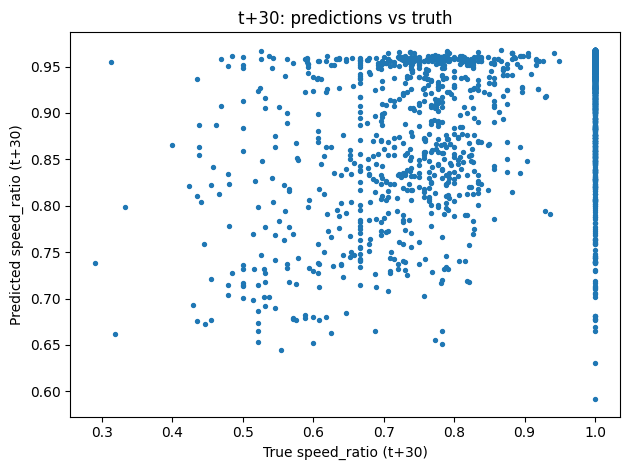

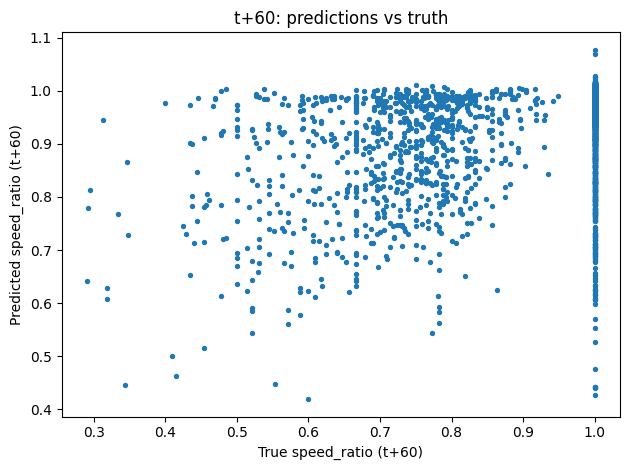

In [131]:
plt.figure()
plt.scatter(y_test_30, pred_30, s=8)
plt.xlabel("True speed_ratio (t+30)")
plt.ylabel("Predicted speed_ratio (t+30)")
plt.title("t+30: predictions vs truth")
plt.tight_layout()
plt.show()

plt.figure()
plt.scatter(y_test_60, pred_60, s=8)
plt.xlabel("True speed_ratio (t+60)")
plt.ylabel("Predicted speed_ratio (t+60)")
plt.title("t+60: predictions vs truth")
plt.tight_layout()
plt.show()


In [ ]:
def train_hgb(X: pd.DataFrame, y: np.ndarray, seed: int = 42) -> HistGradientBoostingRegressor:
    model = HistGradientBoostingRegressor(
        loss="absolute_error",
        learning_rate=0.03,
        max_iter=1000,
        max_leaf_nodes=100,
        min_samples_leaf=80,
        l2_regularization=0.2,
        max_bins=255,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=30,
        random_state=seed,
    )
    model.fit(X, y)
    return model

In [114]:
random_state = 42

X_train = train_df[feature_cols].replace([np.inf, -np.inf], np.nan).fillna(0.0)
X_test  = test_df[feature_cols].replace([np.inf, -np.inf], np.nan).fillna(0.0)

y30_train_speed = train_df[LABEL_30_COL].astype(float).to_numpy()
y60_train_speed = train_df[LABEL_60_COL].astype(float).to_numpy()
y30_test_speed  = test_df[LABEL_30_COL].astype(float).to_numpy()
y60_test_speed  = test_df[LABEL_60_COL].astype(float).to_numpy()

y30_train = to_model_target(y30_train_speed)
y60_train = to_model_target(y60_train_speed)

model_30 = train_hgb(X_train, y30_train, seed=random_state)
pred30_model = model_30.predict(X_test)
pred30_speed = from_model_pred(pred30_model)
metrics_30 = evaluate(y30_test_speed, pred30_speed)

model_60 = train_hgb(X_train, y60_train, seed=random_state + 1)
pred60_model = model_60.predict(X_test)
pred60_speed = from_model_pred(pred60_model)
metrics_60 = evaluate(y60_test_speed, pred60_speed)

metrics = {
    "horizon_30m": metrics_30,
    "horizon_60m": metrics_60,
    "n_train": int(len(train_df)),
    "n_test": int(len(test_df)),
    "feature_count": int(len(feature_cols)),
    "target_as_congestion": bool(TARGET_AS_CONGESTION),
}
metrics


{'horizon_30m': {'mae': 0.04704019660665424, 'rmse': 0.10941011705013669},
 'horizon_60m': {'mae': 0.06210031757928214, 'rmse': 0.13076245850797696},
 'n_train': 15894,
 'n_test': 3974,
 'feature_count': 39,
 'target_as_congestion': False}

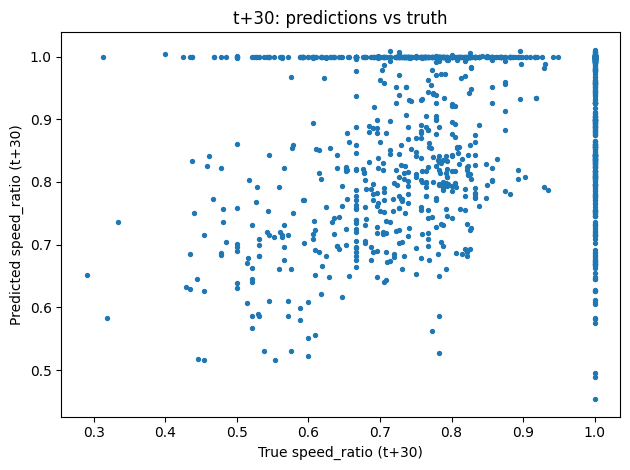

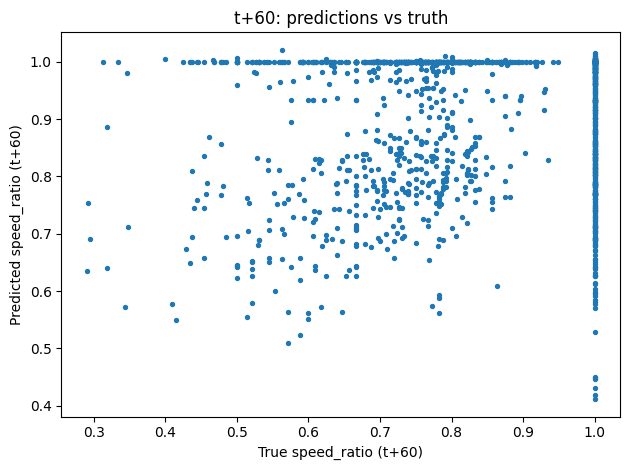

In [115]:
plt.figure()
plt.scatter(y_test_30, pred30_model, s=8)
plt.xlabel("True speed_ratio (t+30)")
plt.ylabel("Predicted speed_ratio (t+30)")
plt.title("t+30: predictions vs truth")
plt.tight_layout()
plt.show()

plt.figure()
plt.scatter(y_test_60, pred60_model, s=8)
plt.xlabel("True speed_ratio (t+60)")
plt.ylabel("Predicted speed_ratio (t+60)")
plt.title("t+60: predictions vs truth")
plt.tight_layout()
plt.show()